In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
import numpy as np

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

In [3]:
class MLP(nn.Module):
    def __init__(self, state_dim,action_dim,hidden_dim=128):
        """ 初始化q网络，为全连接网络
            state_dim: 输入的特征数即环境的状态维度
            action_dim: 输出的动作维度
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, action_dim) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class DoubleDQN:
    
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim  # 总的动作个数
        self.device = cfg.device  # 设备，cpu或gpu等
        self.gamma = cfg.gamma
        # e-greedy策略相关参数
        self.actions_count = 0
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(state_dim, action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        # target_net copy from policy_net
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        # self.target_net.eval()  # 不启用 BatchNormalization 和 Dropout
        # 可查parameters()与state_dict()的区别，前者require_grad=True
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.loss = 0
        self.memory = ReplayBuffer(cfg.memory_capacity)
        
    def choose_action(self, state):
        '''选择动作
        '''
        self.actions_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.actions_count / self.epsilon_decay)
        if random.random() > self.epsilon:
            with torch.no_grad():
                # 先转为张量便于丢给神经网络,state元素数据原本为float64
                # 注意state=torch.tensor(state).unsqueeze(0)跟state=torch.tensor([state])等价
                state = torch.tensor(
                    [state], device=self.device, dtype=torch.float32)
                # 如tensor([[-0.0798, -0.0079]], grad_fn=<AddmmBackward>)
                q_value = self.policy_net(state)
                # tensor.max(1)返回每行的最大值以及对应的下标，
                # 如torch.return_types.max(values=tensor([10.3587]),indices=tensor([0]))
                # 所以tensor.max(1)[1]返回最大值对应的下标，即action
                action = q_value.max(1)[1].item()  
        else:
            action = random.randrange(self.action_dim)
        return action
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        # 从memory中随机采样transition
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # convert to tensor
        state_batch = torch.tensor(
            state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(
            1)  # 例如tensor([[1],...,[0]])
        reward_batch = torch.tensor(
            reward_batch, device=self.device, dtype=torch.float)  # tensor([1., 1.,...,1])
        next_state_batch = torch.tensor(
            next_state_batch, device=self.device, dtype=torch.float)
        
        done_batch = torch.tensor(np.float32(
            done_batch), device=self.device)  # 将bool转为float然后转为张量
        
        # 计算当前(s_t,a)对应的Q(s_t, a)
        q_values = self.policy_net(state_batch) 
        next_q_values = self.policy_net(next_state_batch)
        # 代入当前选择的action，得到Q(s_t|a=a_t)0
        q_value = q_values.gather(dim=1, index=action_batch)
        # q_values是估计值
        '''以下是Nature DQN的q_target计算方式
        # 计算所有next states的Q'(s_{t+1})的最大值，Q'为目标网络的q函数
        next_q_state_value = self.target_net(
            next_state_batch).max(1)[0].detach()  # 比如tensor([ 0.0060, -0.0171,...,])
        # 计算 q_target
        # 对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        q_target = reward_batch + self.gamma * next_q_state_value * (1-done_batch[0])
        '''
        '''以下是Double DQN q_target计算方式，与NatureDQN稍有不同'''
        next_target_values = self.target_net(
            next_state_batch)
        # 选出Q(s_t‘, a)对应的action，代入到next_target_values获得target net对应的next_q_value，即Q’(s_t|a=argmax Q(s_t‘, a))
        next_target_q_value = next_target_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)

#         print('next_q_values:', next_q_values)
#         print('torch.max(next_q_values, 1)[1]: ', torch.max(next_q_values, 1)[1])
#         print('torch.max(next_q_values, 1)[1].unsqueeze(1): ', torch.max(next_q_values, 1)[1].unsqueeze(1))
#         print('next_target_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)): ', next_target_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)))
#         print('final next_target_q_value: ', next_target_q_value)

        q_target = reward_batch + self.gamma * next_target_q_value * (1-done_batch)
        self.loss = nn.MSELoss()(q_value, q_target.unsqueeze(1))  # 计算 均方误差loss
        # 优化模型
        self.optimizer.zero_grad()  # zero_grad清除上一步所有旧的gradients from the last step
        # loss.backward()使用backpropagation计算loss相对于所有parameters(需要gradients)的微分
        self.loss.backward()
        for param in self.policy_net.parameters():  # clip防止梯度爆炸
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # 更新模型
        
    def save(self,path):
        torch.save(self.target_net.state_dict(), path+'checkpoint.pth')

    def load(self,path):
        self.target_net.load_state_dict(torch.load(path+'checkpoint.pth'))  
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)  

In [5]:
import sys,os
curr_path = os.path.dirname(os.path.realpath('__file__')) # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path) # 父路径
sys.path.append(parent_path) # 添加路径到系统路径

import gym
import torch
import datetime

from common.utils import save_results, make_dir
from common.utils import plot_rewards
# from DoubleDQN.double_dqn import DoubleDQN

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [6]:
class Config:
    def __init__(self):
        ################################## 环境超参数 ###################################
        self.algo_name = 'DoubleDQN' # 算法名称
        self.env_name = 'CartPole-v1'  # 环境名称
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # 检测GPU
        self.train_eps = 200  # 训练的回合数
        self.test_eps = 30  # 测试的回合数
        ################################################################################

        ################################## 算法超参数 ###################################
        self.gamma = 0.95  # 强化学习中的折扣因子
        self.epsilon_start = 0.95  # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01  # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500  # e-greedy策略中epsilon的衰减率
        self.lr = 0.0001  # 学习率
        self.memory_capacity = 100000  # 经验回放的容量
        self.batch_size = 64  # mini-batch SGD中的批量大小
        self.target_update = 2  # 目标网络的更新频率
        self.hidden_dim = 256  # 网络隐藏层
        ################################################################################

        ################################# 保存结果相关参数 ##############################
        self.result_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/results/'  # 保存结果的路径
        self.model_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/models/'  # 保存模型的路径
        self.save = True # 是否保存图片
        ################################################################################

In [7]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env_name)  
    env.seed(seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DoubleDQN(state_dim,action_dim,cfg)
    return env,agent

In [8]:
def train(cfg,env,agent):
    print('开始训练!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0 # 记录一回合内的奖励
        state = env.reset() # 重置环境，返回初始状态
        while True:
            action = agent.choose_action(state) 
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done) 
            state = next_state 
            agent.update() 
            if done:
                break
        if i_ep % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i_ep+1)%10 == 0: 
            print(f'回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward}')
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)   
    print('完成训练！')
    env.close()
    return rewards,ma_rewards

def test(cfg,env,agent):
    print('开始测试!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    ############# 由于测试不需要使用epsilon-greedy策略，所以相应的值设置为0 ###############
    cfg.epsilon_start = 0.0  # e-greedy策略中初始epsilon
    cfg.epsilon_end = 0.0  # e-greedy策略中的终止epsilon
    ################################################################################
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    
    for i_ep in range(cfg.test_eps):
        state = env.reset() 
        ep_reward = 0   
        while True:
            action = agent.choose_action(state) 
            next_state, reward, done, _ = env.step(action)  
            state = next_state  
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.1f}")
    print('完成测试！')
    env.close()
    return rewards,ma_rewards  

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


开始训练!
环境：CartPole-v1, 算法：DoubleDQN, 设备：cuda


C:\Users\Administrator\AppData\Local\Temp\ipykernel_113868\4289509214.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor(


回合：10/200，奖励：21.0
回合：20/200，奖励：14.0
回合：30/200，奖励：14.0
回合：40/200，奖励：10.0
回合：50/200，奖励：8.0
回合：60/200，奖励：129.0
回合：70/200，奖励：75.0
回合：80/200，奖励：328.0
回合：90/200，奖励：311.0
回合：100/200，奖励：245.0
回合：110/200，奖励：412.0
回合：120/200，奖励：321.0
回合：130/200，奖励：292.0
回合：140/200，奖励：340.0
回合：150/200，奖励：348.0
回合：160/200，奖励：392.0
回合：170/200，奖励：321.0
回合：180/200，奖励：318.0
回合：190/200，奖励：302.0
回合：200/200，奖励：352.0
完成训练！
结果保存完毕！


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


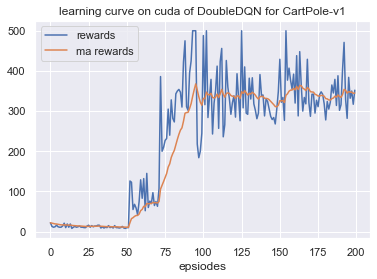

In [9]:
cfg = Config()
# 训练
env, agent = env_agent_config(cfg)
rewards, ma_rewards = train(cfg, env, agent)
make_dir(cfg.result_path, cfg.model_path)  # 创建保存结果和模型路径的文件夹
agent.save(path=cfg.model_path)  # 保存模型
save_results(rewards, ma_rewards, tag='train',
             path=cfg.result_path)  # 保存结果
plot_rewards(rewards, ma_rewards, cfg, tag="train")  # 画出结果

开始测试!
环境：CartPole-v1, 算法：DoubleDQN, 设备：cuda
回合：1/30，奖励：14.0
回合：2/30，奖励：27.0
回合：3/30，奖励：33.0
回合：4/30，奖励：11.0
回合：5/30，奖励：69.0
回合：6/30，奖励：27.0
回合：7/30，奖励：203.0
回合：8/30，奖励：246.0
回合：9/30，奖励：290.0
回合：10/30，奖励：343.0
回合：11/30，奖励：316.0
回合：12/30，奖励：299.0
回合：13/30，奖励：325.0
回合：14/30，奖励：356.0
回合：15/30，奖励：290.0
回合：16/30，奖励：351.0
回合：17/30，奖励：328.0
回合：18/30，奖励：310.0
回合：19/30，奖励：318.0
回合：20/30，奖励：289.0
回合：21/30，奖励：328.0
回合：22/30，奖励：323.0
回合：23/30，奖励：341.0
回合：24/30，奖励：355.0
回合：25/30，奖励：347.0
回合：26/30，奖励：310.0
回合：27/30，奖励：325.0
回合：28/30，奖励：344.0
回合：29/30，奖励：334.0
回合：30/30，奖励：338.0
完成测试！
结果保存完毕！


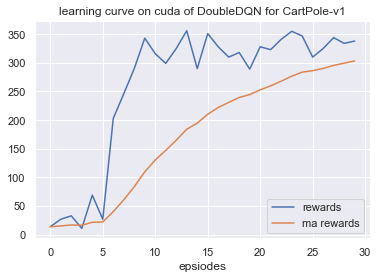

In [10]:
# 测试
env, agent = env_agent_config(cfg)
agent.load(path=cfg.model_path)  # 导入模型
rewards, ma_rewards = test(cfg, env, agent)
save_results(rewards, ma_rewards, tag='test',
             path=cfg.result_path)  # 保存结果
plot_rewards(rewards, ma_rewards, cfg, tag="test")  # 画出结果